# Importing Necessary Libraries  

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import pickle # for saving the model

# Loading Dataset

In [2]:
features = pd.read_csv(r"C:\Users\SINDHU\Downloads\features.csv")
train = pd.read_csv(r"C:\Users\SINDHU\Downloads\train (1).csv")
stores = pd.read_csv(r"C:\Users\SINDHU\Downloads\stores.csv")
test = pd.read_csv(r"C:\Users\SINDHU\Downloads\test (1).csv")
sample_output = pd.read_csv(r"C:\Users\SINDHU\Downloads\sampleoutput.csv")

# Data Merging

In [3]:
feat_sto = features.merge(stores, how='inner', on='Store')

# Data Exploration

In [4]:
feat_sto.head()

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday Type  \
0        NaN        NaN        NaN  211.096358         8.106      False    A   
1        NaN        NaN        NaN  211.242170         8.106       True    A   
2        NaN        NaN        NaN  211.289143         8.106      False    A   
3        NaN        NaN        NaN  211.319643         8.106      False    A   
4        NaN        NaN        NaN  211.350143         8.106      False    A   

     Size  
0  151315  
1  151315  
2  151315  
3  151315  
4  151315

In [5]:
pd.DataFrame(feat_sto.dtypes, columns=['Type'])

Type
Store           int64
Date           object
Temperature   float64
Fuel_Price    float64
MarkDown1     float64
MarkDown2     float64
MarkDown3     float64
MarkDown4     float64
MarkDown5     float64
CPI           float64
Unemployment  float64
IsHoliday        bool
Type           object
Size            int64

In [6]:
pd.DataFrame({'Type_Train': train.dtypes, 'Type_Test': test.dtypes})

Type_Train Type_Test
Date             object    object
Dept              int64     int64
IsHoliday          bool      bool
Store             int64     int64
Weekly_Sales    float64       NaN

# Data Preprocessing

In [7]:
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [8]:
feat_sto['Week'] = feat_sto.Date.dt.week 
feat_sto['Year'] = feat_sto.Date.dt.year

In [9]:
train_detail = train.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [10]:
train_detail.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment Type    Size  Week  Year  
0         8.106    A  151315     5  2010  
1         8.106    A  151315     6  2010  
2         8.106    A  151315     7  2010  
3         8.106    A  151315     8  2010  
4         8.106    A  151315     9  2010

In [11]:
test_detail = test.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [12]:
del features, train, stores, test

# Checking Missing Values

In [13]:
null_columns = (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False).index
null_data = pd.concat([
    train_detail.isnull().sum(axis = 0),
    (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False),
    train_detail.loc[:, train_detail.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data

# null    % null     type
MarkDown2  310322  0.736110  float64
MarkDown4  286603  0.679847  float64
MarkDown3  284479  0.674808  float64
MarkDown1  270889  0.642572  float64
MarkDown5  270138  0.640790  float64

# SQL Query for Labeling Holidays and Days

In [14]:
pysqldf("""
SELECT
    T.*,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Super Bowl'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Labor Day'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thanksgiving'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 then 'Christmas'
    end as Holyday,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Monday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thursday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2010 then 'Saturday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2011 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2012 then 'Tuesday'
    end as Day
    from(
        SELECT DISTINCT
            Year,
            Week,
            case 
                when Date <= '2012-11-01' then 'Train Data' else 'Test Data' 
            end as Data_type
        FROM feat_sto
        WHERE IsHoliday = True) as T""")

Year  Week   Data_type       Holyday       Day
0   2010     6  Train Data    Super Bowl    Sunday
1   2010    36  Train Data     Labor Day    Monday
2   2010    47  Train Data  Thanksgiving  Thursday
3   2010    52  Train Data     Christmas  Saturday
4   2011     6  Train Data    Super Bowl    Sunday
5   2011    36  Train Data     Labor Day    Monday
6   2011    47  Train Data  Thanksgiving  Thursday
7   2011    52  Train Data     Christmas    Sunday
8   2012     6  Train Data    Super Bowl    Sunday
9   2012    36  Train Data     Labor Day    Monday
10  2012    47   Test Data  Thanksgiving  Thursday
11  2012    52   Test Data     Christmas   Tuesday
12  2013     6   Test Data    Super Bowl    Sunday

# Data Visualization 

# Average of Weekly Sales

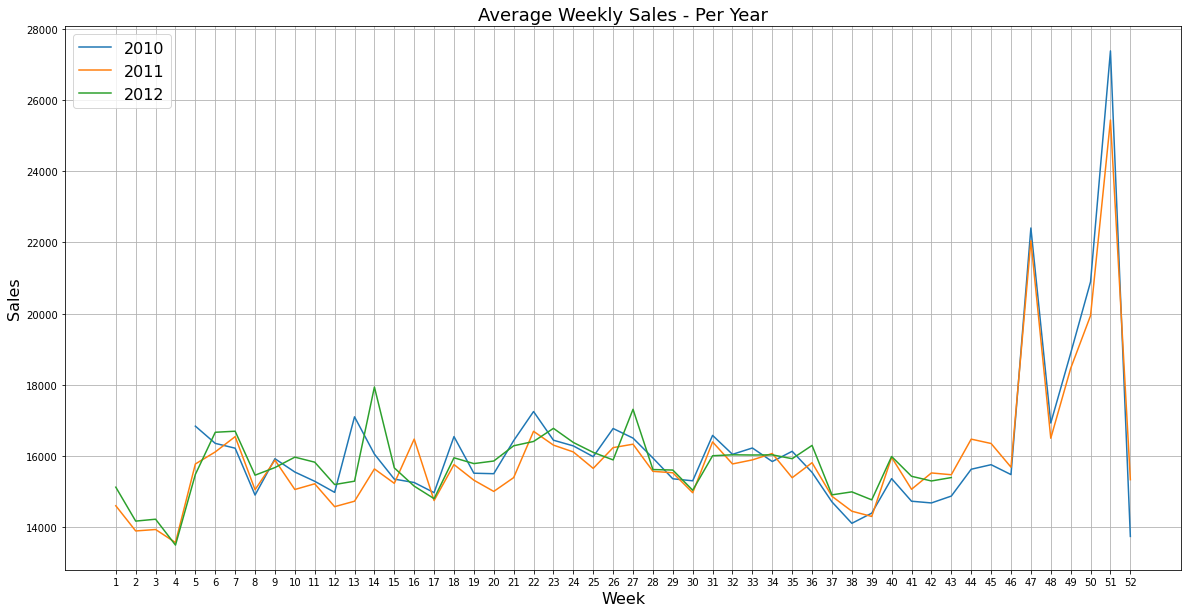

In [15]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()
plt.figure(figsize=(20,10))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

In [16]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

# Mean and Median of weekly sales

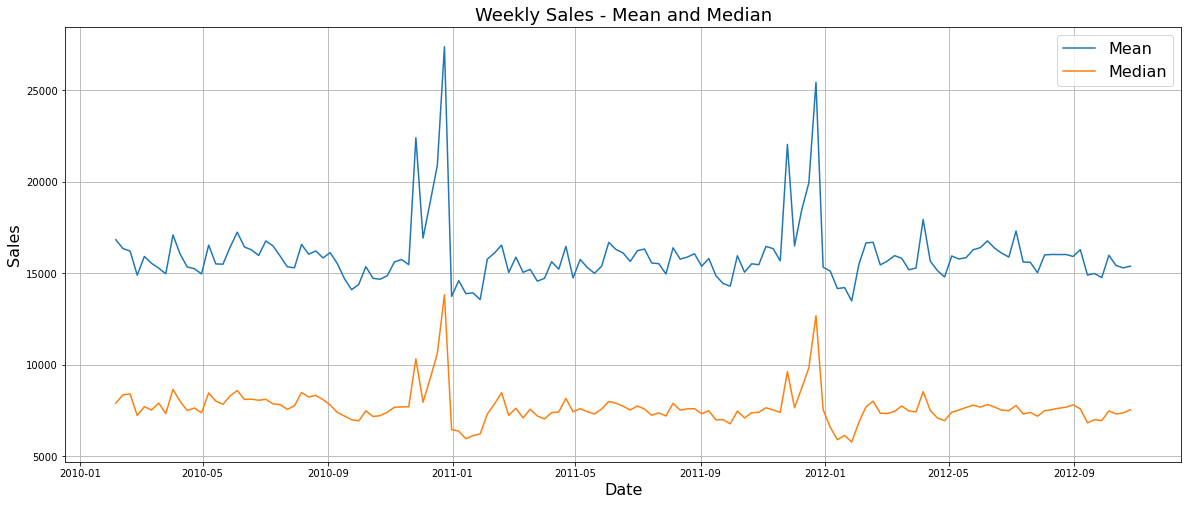

In [17]:
weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()

plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)

plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

# Average of Sales per store and department

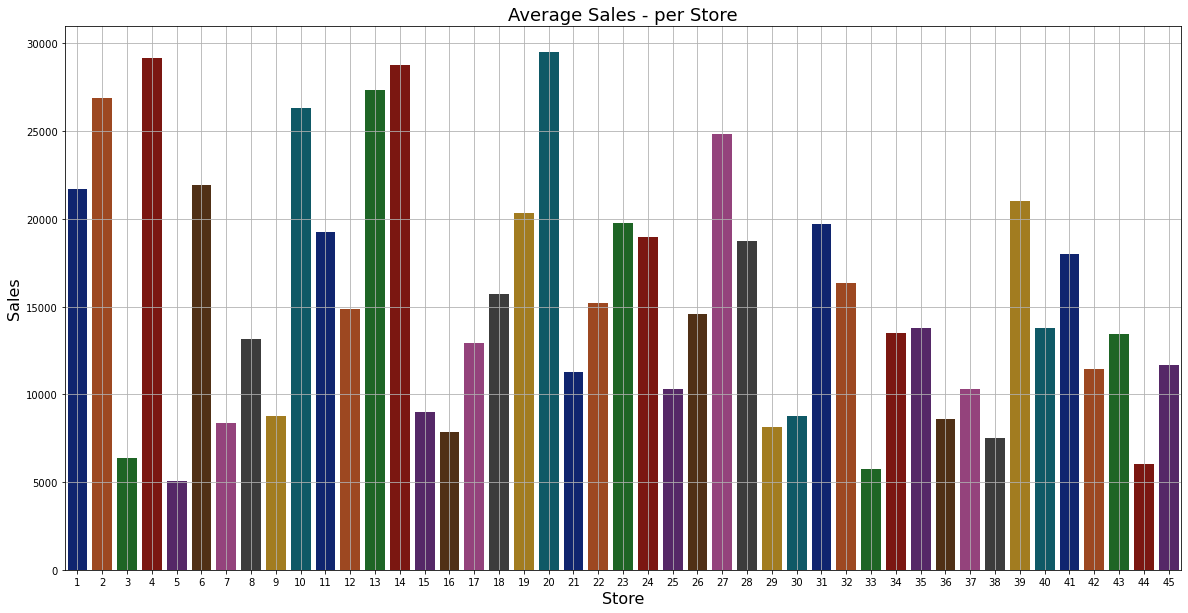

In [18]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,10))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

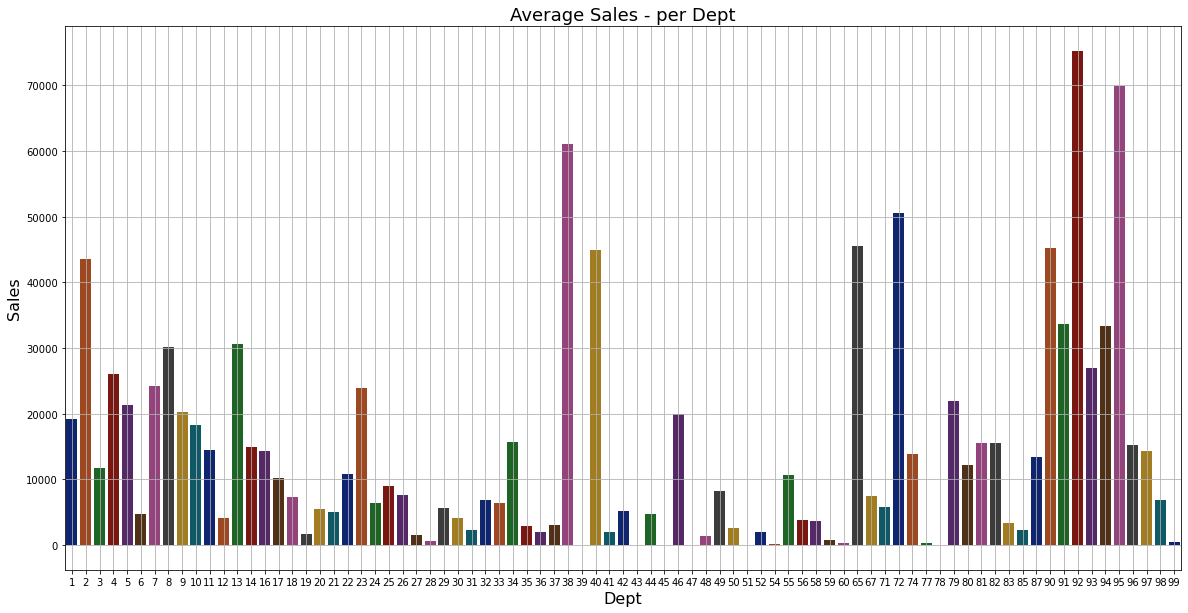

In [19]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(20,10))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

# Correlation matrix

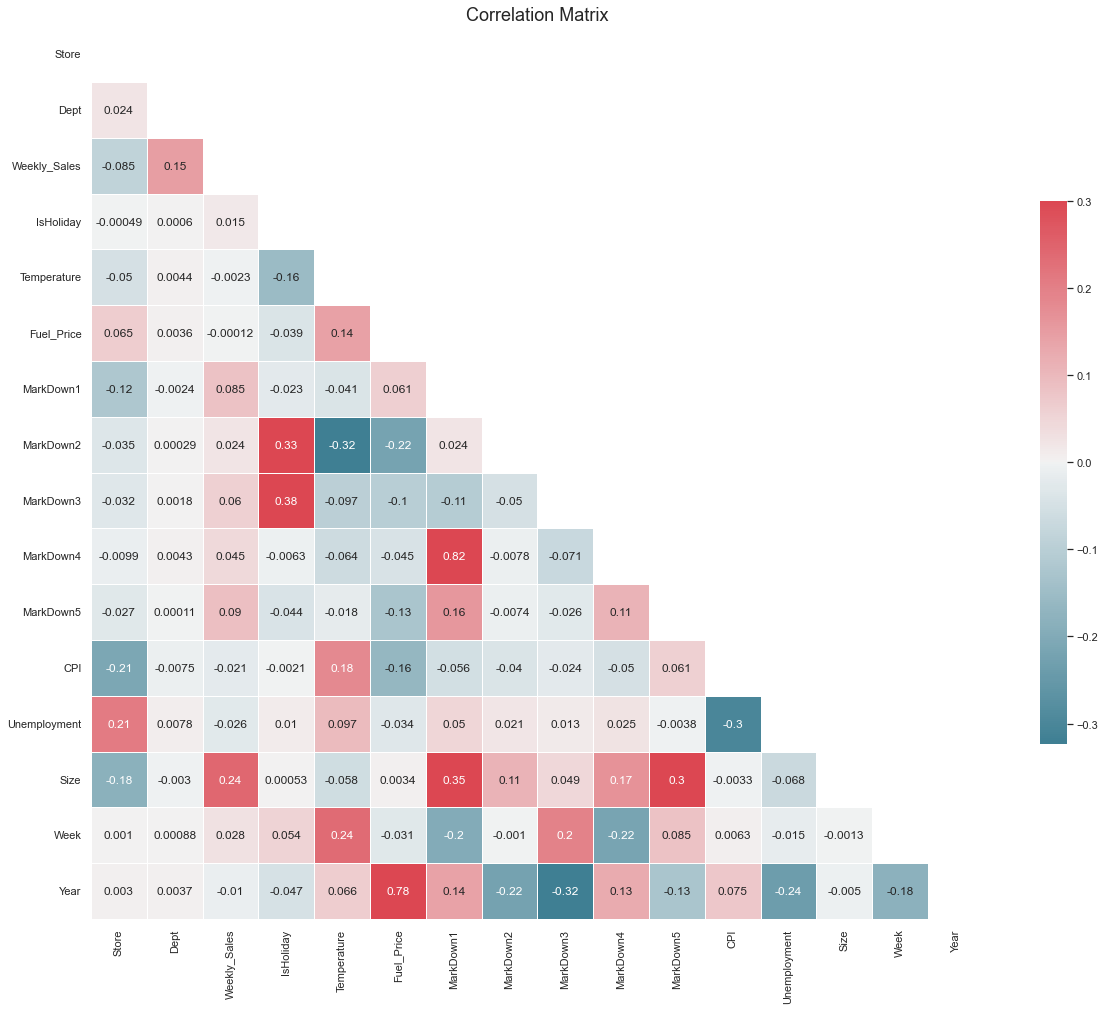

In [20]:
sns.set(style="white")

corr = train_detail.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

# Dropping Irrelevant Features

In [21]:
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

# Boxplot Analysis

In [22]:
def boxplot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

In [23]:
def boxcox(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.15)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[1,1]), color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    
    fig.show()

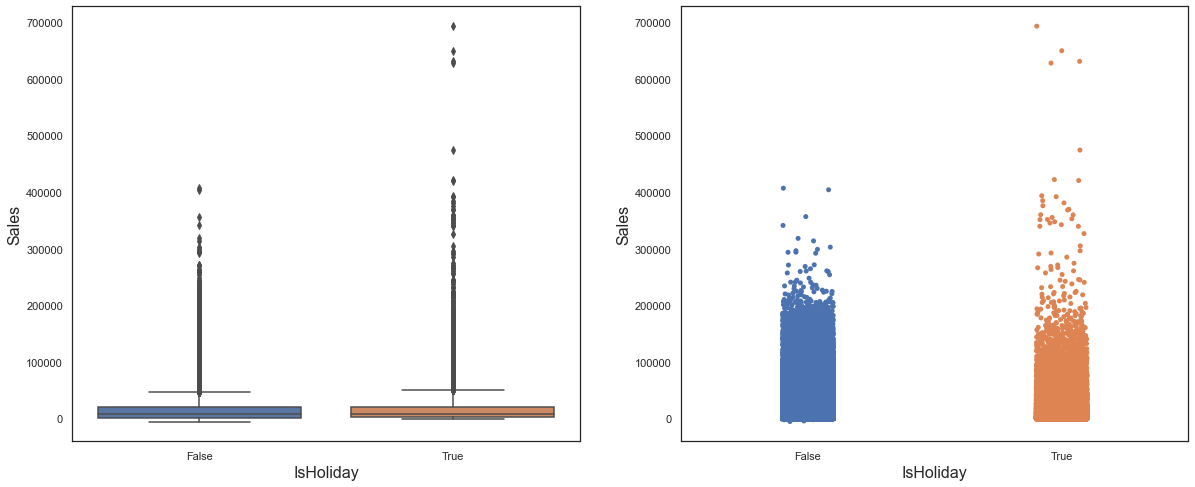

In [24]:
boxplot('IsHoliday')

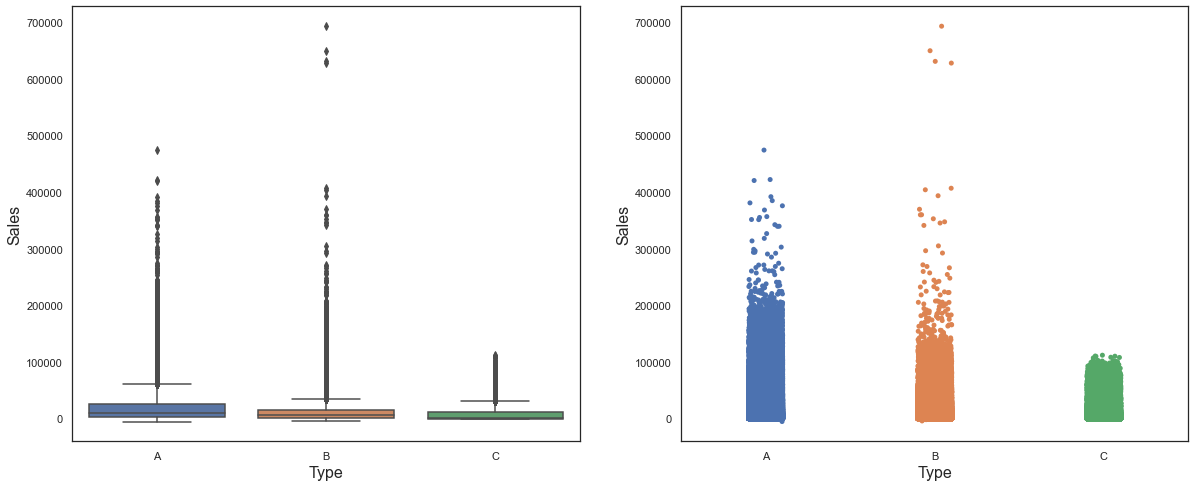

In [25]:
boxplot('Type')

In [26]:
train_detail.Type = train_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

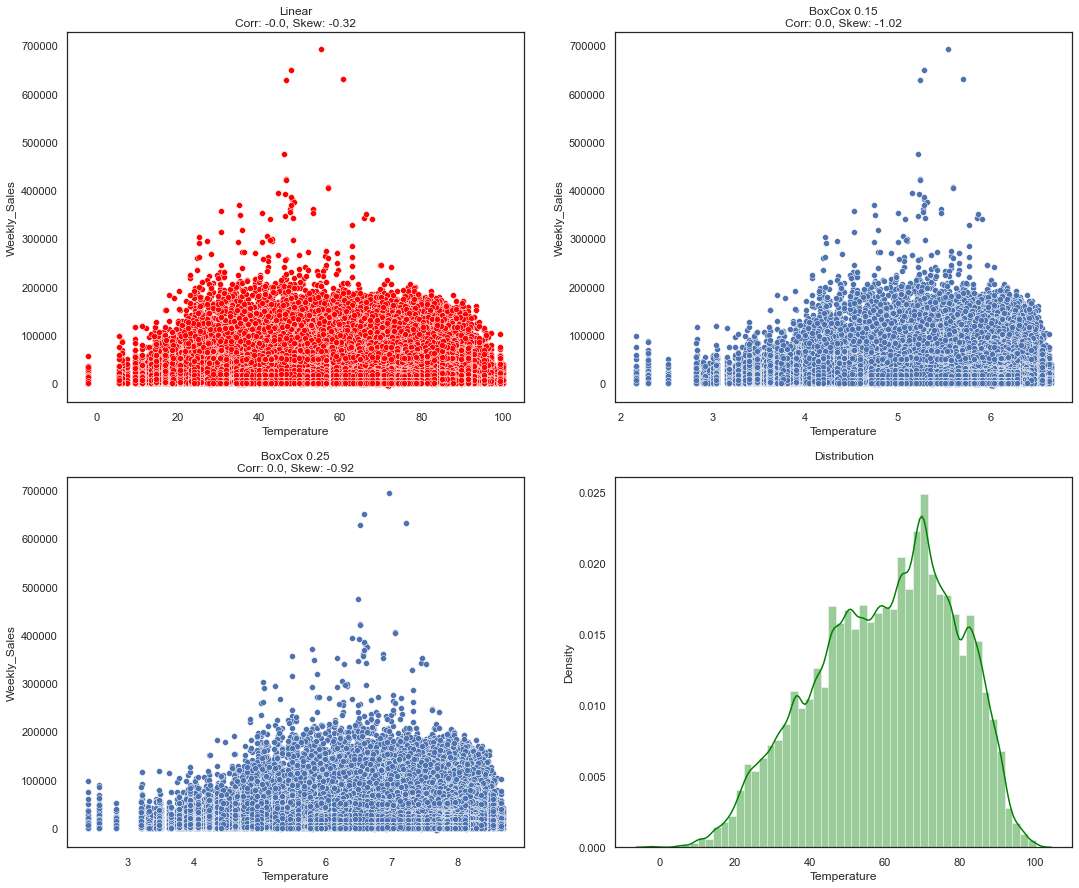

In [27]:
boxcox('Temperature')

In [28]:
train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])

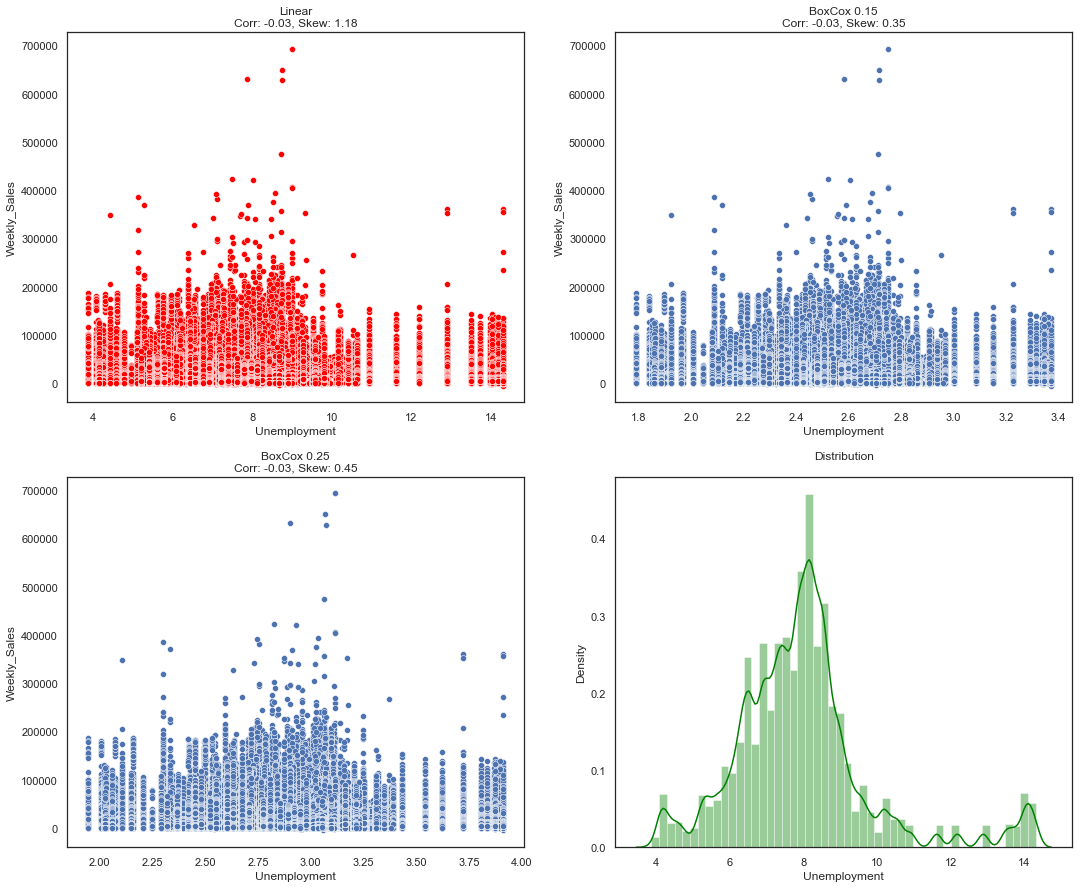

In [29]:
boxcox('Unemployment')

# Dropping Columns

In [30]:
train_detail = train_detail.drop(columns=['Unemployment'])
test_detail = test_detail.drop(columns=['Unemployment'])

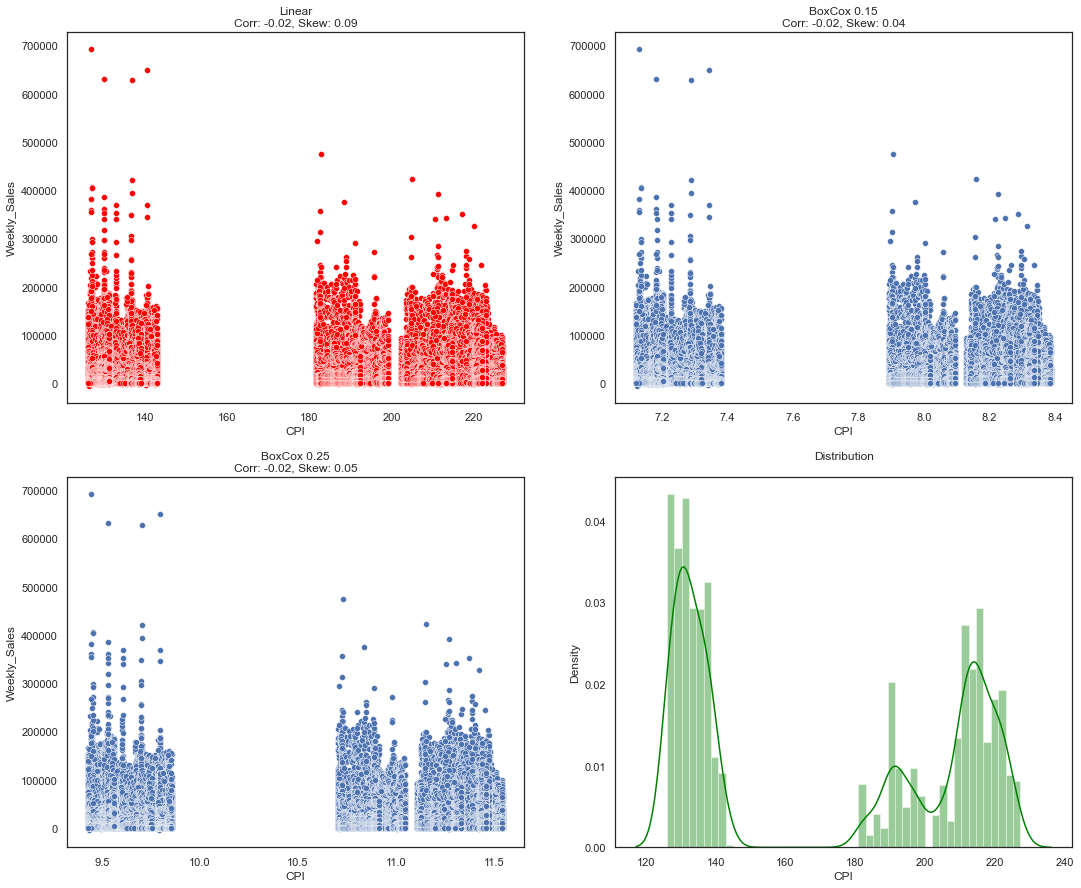

In [31]:
boxcox('CPI')

In [32]:
train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])

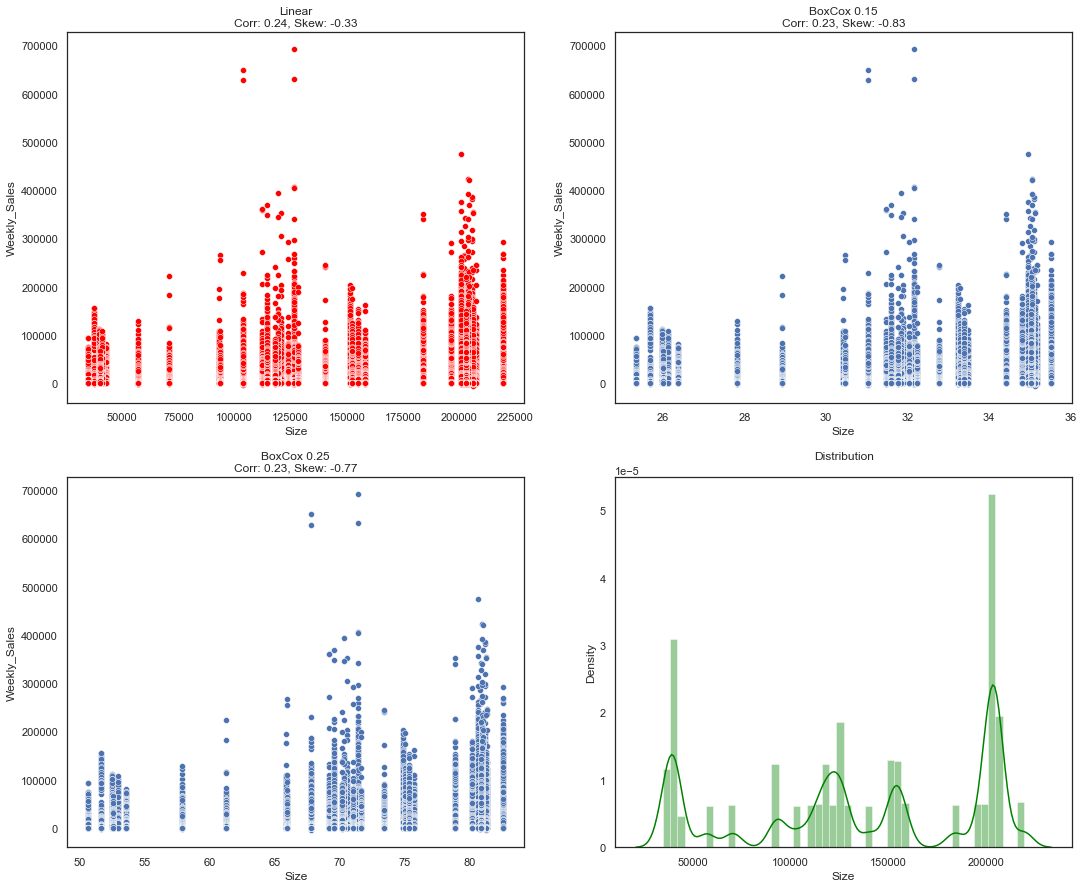

In [33]:
boxcox('Size')

In [34]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

# Preview of Training and Testing Data

In [35]:
train_detail

Store  Dept       Date  Weekly_Sales  IsHoliday  Type    Size  Week  \
0           1     1 2010-02-05      24924.50      False     3  151315     5   
1           1     1 2010-02-12      46039.49       True     3  151315     6   
2           1     1 2010-02-19      41595.55      False     3  151315     7   
3           1     1 2010-02-26      19403.54      False     3  151315     8   
4           1     1 2010-03-05      21827.90      False     3  151315     9   
...       ...   ...        ...           ...        ...   ...     ...   ...   
421565     45    98 2012-09-28        508.37      False     2  118221    39   
421566     45    98 2012-10-05        628.10      False     2  118221    40   
421567     45    98 2012-10-12       1061.02      False     2  118221    41   
421568     45    98 2012-10-19        760.01      False     2  118221    42   
421569     45    98 2012-10-26       1076.80      False     2  118221    43   

        Year  
0       2010  
1       2010  
2       2010  
3       2010  
4       2010  
...      ...  
421565  2012  
421566  2012  
421567  2012  
421568  2012  
421569  2012  

[421570 rows x 9 columns]

In [36]:
test_detail

Store  Dept       Date  IsHoliday  Type    Size  Week  Year
0           1     1 2012-11-02      False     3  151315    44  2012
1           1     1 2012-11-09      False     3  151315    45  2012
2           1     1 2012-11-16      False     3  151315    46  2012
3           1     1 2012-11-23       True     3  151315    47  2012
4           1     1 2012-11-30      False     3  151315    48  2012
...       ...   ...        ...        ...   ...     ...   ...   ...
115059     45    98 2013-06-28      False     2  118221    26  2013
115060     45    98 2013-07-05      False     2  118221    27  2013
115061     45    98 2013-07-12      False     2  118221    28  2013
115062     45    98 2013-07-19      False     2  118221    29  2013
115063     45    98 2013-07-26      False     2  118221    30  2013

[115064 rows x 8 columns]

# Model Functions

In [37]:
def knn():
    knn = KNeighborsRegressor(n_neighbors=10)
    return knn

def extraTreesRegressor():
    clf = ExtraTreesRegressor(n_estimators=60, max_features=3, verbose=1, n_jobs=1)
    return clf
    
def randomForestRegressor():
    clf = RandomForestRegressor(n_estimators = 100, max_features = 'log2', verbose = 1, bootstrap = True)
    return clf

def linear_reg():
    regr = LinearRegression()
    return regr

def predict_(m, test_x):
    return pd.Series(m.predict(test_x))

def model_():
#     return knn()
#     return extraTreesRegressor()
    return randomForestRegressor()   
#     return linear_reg()

def train_(train_x, train_y):
    m = model_()
    m.fit(train_x, train_y)
    return m

def train_and_predict(train_x, train_y, test_x):
    m = train_(train_x, train_y)
    return predict_(m, test_x), m

# K-Fold Cross Validation 

In [38]:
kf = KFold(n_splits=5)
splited = []
# dataset2 = dataset.copy()
for name, group in train_detail.groupby(["Store", "Dept"]):
    group = group.reset_index(drop=True)
    trains_x = []
    trains_y = []
    tests_x = []
    tests_y = []
    if group.shape[0] <= 5:
        f = np.array(range(5))
        np.random.shuffle(f)
        group['fold'] = f[:group.shape[0]]
        continue
    fold = 0
    for train_index, test_index in kf.split(group):
        group.loc[test_index, 'fold'] = fold
        fold += 1
    splited.append(group)

splited = pd.concat(splited).reset_index(drop=True)

In [39]:
splited

Store  Dept       Date  Weekly_Sales  IsHoliday  Type    Size  Week  \
0           1     1 2010-02-05      24924.50      False     3  151315     5   
1           1     1 2010-02-12      46039.49       True     3  151315     6   
2           1     1 2010-02-19      41595.55      False     3  151315     7   
3           1     1 2010-02-26      19403.54      False     3  151315     8   
4           1     1 2010-03-05      21827.90      False     3  151315     9   
...       ...   ...        ...           ...        ...   ...     ...   ...   
421269     45    98 2012-09-28        508.37      False     2  118221    39   
421270     45    98 2012-10-05        628.10      False     2  118221    40   
421271     45    98 2012-10-12       1061.02      False     2  118221    41   
421272     45    98 2012-10-19        760.01      False     2  118221    42   
421273     45    98 2012-10-26       1076.80      False     2  118221    43   

        Year  fold  
0       2010   0.0  
1       2010   0.0  
2       2010   0.0  
3       2010   0.0  
4       2010   0.0  
...      ...   ...  
421269  2012   4.0  
421270  2012   4.0  
421271  2012   4.0  
421272  2012   4.0  
421273  2012   4.0  

[421274 rows x 10 columns]

# Model Training and Error Calculation

In [40]:
best_model = None
error_cv = 0
best_error = np.iinfo(np.int32).max
for fold in range(5):
    train_detail2 = splited.loc[splited['fold'] != fold]
    test_detail2 = splited.loc[splited['fold'] == fold]
    train_y = train_detail2['Weekly_Sales']
    train_x = train_detail2[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
    test_y = test_detail2['Weekly_Sales']
    test_x = test_detail2[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
    print(train_detail2.shape, test_detail2.shape)
    predicted, model = train_and_predict(train_x, train_y, test_x)
#     weights = test_x['isHoliday'].replace(True, 5).replace(False, 1)
#     error = calculate_error(test_y, predicted, weights)
    error = WMAE(test_x, test_y, predicted)
    print(error)
    error_cv += error
    print(fold, error)
    if error < best_error:
        print('Find best model')
        best_error = error
        best_model = model
error_cv /= 5

(335722, 10) (85552, 10)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   25.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    8.6s


3747.85
0 3747.85
Find best model
(335849, 10) (85425, 10)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   24.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s


3920.27
1 3920.27
(335970, 10) (85304, 10)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   23.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.4s


3903.71
2 3903.71
(338733, 10) (82541, 10)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   24.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.8s


3822.38
3 3822.38
(338822, 10) (82452, 10)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   24.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.7s


3660.68
4 3660.68
Find best model


In [41]:
error_cv # Average Error

3810.978

In [42]:
best_error #least error

3660.68

# Hyperparameter Tuning

In [43]:
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [44]:
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [45]:
def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

# Model Training

In [46]:
X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_detail['Weekly_Sales']

In [47]:
n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]

random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 56 , max_depth: 25
k: 2 , n_estimators: 56 , max_depth: 25
k: 3 , n_estimators: 56 , max_depth: 25
k: 4 , n_estimators: 56 , max_depth: 25
WMAE: 1554.29
k: 1 , n_estimators: 56 , max_depth: 27
k: 2 , n_estimators: 56 , max_depth: 27
k: 3 , n_estimators: 56 , max_depth: 27
k: 4 , n_estimators: 56 , max_depth: 27
WMAE: 1551.635
k: 1 , n_estimators: 56 , max_depth: 30
k: 2 , n_estimators: 56 , max_depth: 30
k: 3 , n_estimators: 56 , max_depth: 30
k: 4 , n_estimators: 56 , max_depth: 30
WMAE: 1546.4150000000002
k: 1 , n_estimators: 58 , max_depth: 25
k: 2 , n_estimators: 58 , max_depth: 25
k: 3 , n_estimators: 58 , max_depth: 25
k: 4 , n_estimators: 58 , max_depth: 25
WMAE: 1555.7050000000002
k: 1 , n_estimators: 58 , max_depth: 27
k: 2 , n_estimators: 58 , max_depth: 27
k: 3 , n_estimators: 58 , max_depth: 27
k: 4 , n_estimators: 58 , max_depth: 27
WMAE: 1535.2350000000001
k: 1 , n_estimators: 58 , max_depth: 30
k: 2 , n_estimators: 58 , max_depth: 30
k: 3 , n_estimat

Max_Depth  Estimators       WMAE
0         25          56  1554.2900
1         27          56  1551.6350
2         30          56  1546.4150
3         25          58  1555.7050
4         27          58  1535.2350
5         30          58  1547.0825
6         25          60  1545.7775
7         27          60  1536.1450
8         30          60  1550.8000

In [48]:
max_features = [2, 3, 4, 5, 6, 7]

random_forest_II(n_estimators=56, max_depth=30, max_features=max_features)

k: 1 , max_features: 2
k: 2 , max_features: 2
k: 3 , max_features: 2
k: 4 , max_features: 2
WMAE: 4632.717500000001
k: 1 , max_features: 3
k: 2 , max_features: 3
k: 3 , max_features: 3
k: 4 , max_features: 3
WMAE: 2683.38
k: 1 , max_features: 4
k: 2 , max_features: 4
k: 3 , max_features: 4
k: 4 , max_features: 4
WMAE: 1794.8475
k: 1 , max_features: 5
k: 2 , max_features: 5
k: 3 , max_features: 5
k: 4 , max_features: 5
WMAE: 1585.7724999999998
k: 1 , max_features: 6
k: 2 , max_features: 6
k: 3 , max_features: 6
k: 4 , max_features: 6
WMAE: 1526.4775000000002
k: 1 , max_features: 7
k: 2 , max_features: 7
k: 3 , max_features: 7
k: 4 , max_features: 7
WMAE: 1545.1799999999998


Max_Feature       WMAE
0            2  4632.7175
1            3  2683.3800
2            4  1794.8475
3            5  1585.7725
4            6  1526.4775
5            7  1545.1800

In [49]:
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]

random_forest_III(n_estimators=56, max_depth=30, max_features=7, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

k: 1 , min_samples_split: 2 , min_samples_leaf: 1
k: 2 , min_samples_split: 2 , min_samples_leaf: 1
k: 3 , min_samples_split: 2 , min_samples_leaf: 1
k: 4 , min_samples_split: 2 , min_samples_leaf: 1
WMAE: 1548.3449999999998
k: 1 , min_samples_split: 2 , min_samples_leaf: 2
k: 2 , min_samples_split: 2 , min_samples_leaf: 2
k: 3 , min_samples_split: 2 , min_samples_leaf: 2
k: 4 , min_samples_split: 2 , min_samples_leaf: 2
WMAE: 1610.8325
k: 1 , min_samples_split: 2 , min_samples_leaf: 3
k: 2 , min_samples_split: 2 , min_samples_leaf: 3
k: 3 , min_samples_split: 2 , min_samples_leaf: 3
k: 4 , min_samples_split: 2 , min_samples_leaf: 3
WMAE: 1647.9199999999998
k: 1 , min_samples_split: 3 , min_samples_leaf: 1
k: 2 , min_samples_split: 3 , min_samples_leaf: 1
k: 3 , min_samples_split: 3 , min_samples_leaf: 1
k: 4 , min_samples_split: 3 , min_samples_leaf: 1
WMAE: 1543.6299999999999
k: 1 , min_samples_split: 3 , min_samples_leaf: 2
k: 2 , min_samples_split: 3 , min_samples_leaf: 2
k: 3 , mi

Min_Samples_Leaf  Min_Samples_Split       WMAE
0                 1                  2  1548.3450
1                 2                  2  1610.8325
2                 3                  2  1647.9200
3                 1                  3  1543.6300
4                 2                  3  1619.0700
5                 3                  3  1653.5625
6                 1                  4  1556.2150
7                 2                  4  1585.7325
8                 3                  4  1643.5875

# Final Model Training

In [50]:
RF = RandomForestRegressor(n_estimators=56, max_depth=30, max_features=7, min_samples_split=3, min_samples_leaf=1)
RF.fit(X_train, Y_train)

RandomForestRegressor(max_depth=30, max_features=7, min_samples_split=3,
                      n_estimators=56)

# saving the Trained model

In [51]:
model_save_file = open("SavedModel.sav", 'wb')
pickle.dump(RF, model_save_file)
model_save_file.close()

In [52]:
load_saved_model_file = open('SavedModel.sav', 'rb')
loaded_model = pickle.load(load_saved_model_file)
load_saved_model_file.close()

# Model Prediction

In [53]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
loaded_predict = loaded_model.predict(X_test)

In [54]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test)

In [55]:
print(np.all(loaded_predict==predict)) # to show that saved model is loading perfectly by comparing the predictions
# True if all elements are equal, False otherwise.

True


In [56]:
sample_output['Weekly_Sales'] = loaded_predict

In [57]:
sample_output

Id  Weekly_Sales
0         1_1_2012-11-02  29662.933640
1         1_1_2012-11-09  18953.984643
2         1_1_2012-11-16  18983.537083
3         1_1_2012-11-23  20027.099202
4         1_1_2012-11-30  23901.490991
...                  ...           ...
115059  45_98_2013-06-28    671.160280
115060  45_98_2013-07-05    672.746857
115061  45_98_2013-07-12    694.894134
115062  45_98_2013-07-19    757.524048
115063  45_98_2013-07-26    673.324274

[115064 rows x 2 columns]

In [58]:
sample_output.to_csv('output.csv', index=False)

# Download Prediction Results

In [60]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "final_output.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(sample_output)